CLUSTERING ALGORITHMS

In [1]:
from sklearn.cluster import HDBSCAN
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Data Import + Treatment

In [2]:
def plot_model(model, X):
    labels = model.labels_
    palette = plt.get_cmap('tab20')
    unique_labels = sorted(set(labels))

    color_map = {}
    color_map[-1] = (0.6,0.6,0.6,0.6)
    cluster_ids = [l for l in unique_labels if l != -1]
    for i,l in enumerate(cluster_ids):
        color_map[l] = palette(i % 20)

    plt.figure(figsize=(10,7))
    for l in unique_labels:
        mask = labels == l
        label_name = 'noise' if l == -1 else f'cluster {l}'
        plt.scatter(X[mask,1], X[mask,0], s=12, color=color_map[l], label=label_name, alpha=0.8)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'HDBSCAN clusters (sample size={len(X)}) — clusters={len(cluster_ids)}')
    plt.legend(markerscale=2, fontsize='small', loc='best')
    plt.tight_layout()
    plt.show()

In [3]:
def plot_if(model, X):
    """
    Plot IsolationForest results with inliers/outliers and anomaly score heatmap.
    X should be (n_samples, 2) with columns [lat, long]
    """
    labels = model.predict(X)
    scores = model.score_samples(X)
    
    inlier_mask = labels == 1
    outlier_mask = labels == -1
    
    # Create figure with anomaly score heatmap background
    plt.figure(figsize=(12, 8))
    
    # Create mesh for decision boundary
    min_lat, max_lat = X[:, 0].min(), X[:, 0].max()
    min_long, max_long = X[:, 1].min(), X[:, 1].max()
    
    margin_lat = max(0.05 * (max_lat - min_lat), 0.01)
    margin_long = max(0.05 * (max_long - min_long), 0.01)
    
    xx, yy = np.meshgrid(
        np.linspace(min_long - margin_long, max_long + margin_long, 150),
        np.linspace(min_lat - margin_lat, max_lat + margin_lat, 150)
    )
    
    grid = np.c_[yy.ravel(), xx.ravel()]  # [lat, long]
    Z = model.score_samples(grid)
    Z = Z.reshape(xx.shape)
    
    # Plot anomaly score as background
    contourf = plt.contourf(xx, yy, Z, levels=15, cmap='RdYlGn', alpha=0.6)
    plt.colorbar(contourf, label='Anomaly Score (higher=more anomalous)')
    
    # Plot decision boundary (score = 0)
    contour = plt.contour(xx, yy, Z, levels=[0], linewidths=2.5, colors='black', linestyles='dashed')
    
    # Plot training inliers and outliers
    plt.scatter(X[inlier_mask, 1], X[inlier_mask, 0], 
                c='blue', label='Inliers', s=30, edgecolor='darkblue', alpha=0.7)
    plt.scatter(X[outlier_mask, 1], X[outlier_mask, 0], 
                c='red', label='Outliers', s=30, marker='x', linewidth=2)
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'IsolationForest: Inliers vs Outliers (sample size={len(X)}) — outliers={outlier_mask.sum()}')
    plt.legend(markerscale=1.5, fontsize='small', loc='best')
    plt.tight_layout()
    plt.show()


In [4]:
data = pd.read_table("../data/data_cleaned.csv", sep=",")
coords = data[['id','lat','long']].dropna()

'''
sample_size = 1000
if len(coords) > sample_size:
    sample = coords[:sample_size]
    #sample = coords.sample(n=sample_size, random_state=0) If random sampling
else:
    sample = coords
'''

sample = coords
X = sample[['lat','long']].to_numpy()



/tmp/ipykernel_12791/3354656609.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_table("../data/data_cleaned.csv", sep=",")


DBSCAN

DBSCAN randomly selects a data point and checks if it has enough neighbors within a specified radius.
If the point has enough neighbors, it is marked as part of a cluster.
DBSCAN recursively checks if the neighbors also have enough neighbors within the radius until all points in the cluster have been visited.
Repeat steps 1–3 until the remaining data point do not have enough neighbors in the radius.
Remaining data points are marked as outliers.

/tmp/ipykernel_12791/3641340220.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


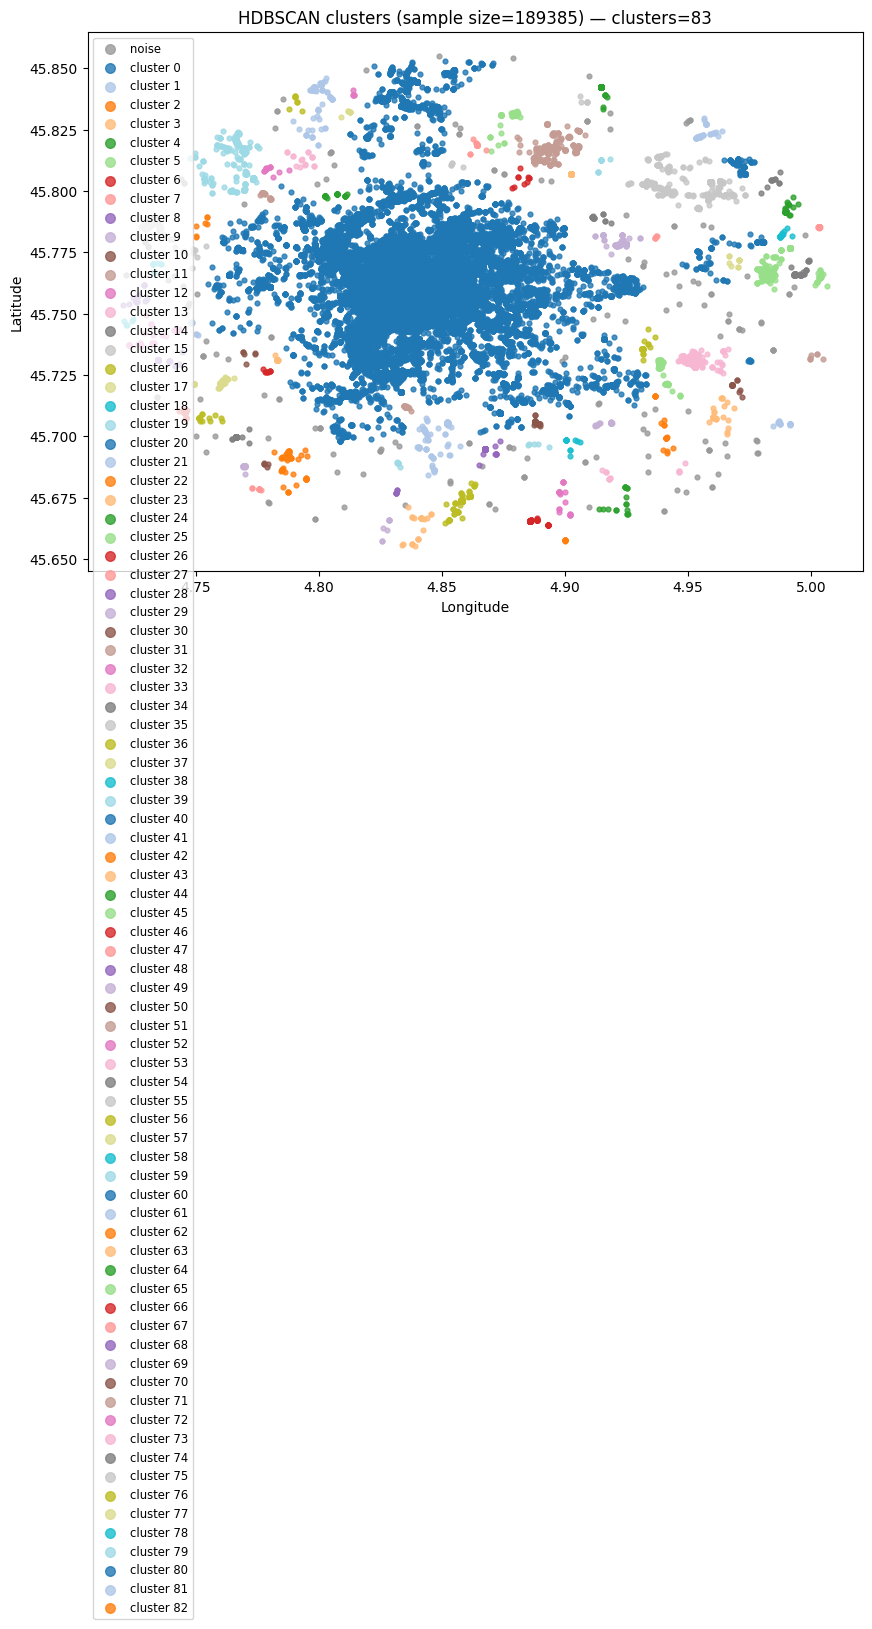

In [5]:
# eps to define max distance to cluster together
# n_jobs parallelises the calculation. -1 means use all processors
dbscan_clusterer = DBSCAN(eps=0.005, min_samples=5, metric='euclidean', n_jobs=-1)
dbscan_clusterer.fit_predict(X)

plot_model(dbscan_clusterer, X)

HDBSCAN

Next, we have hierarchical clustering. This method starts off by computing a distance matrix from the raw data. This distance matrix is best and often visualized by a dendrogram. Data points are linked together one by one by finding the nearest neighbor to eventually form one giant cluster. Therefore, a cut-off point to identify the clusters by stopping all data points from linking together.

/tmp/ipykernel_12791/3641340220.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


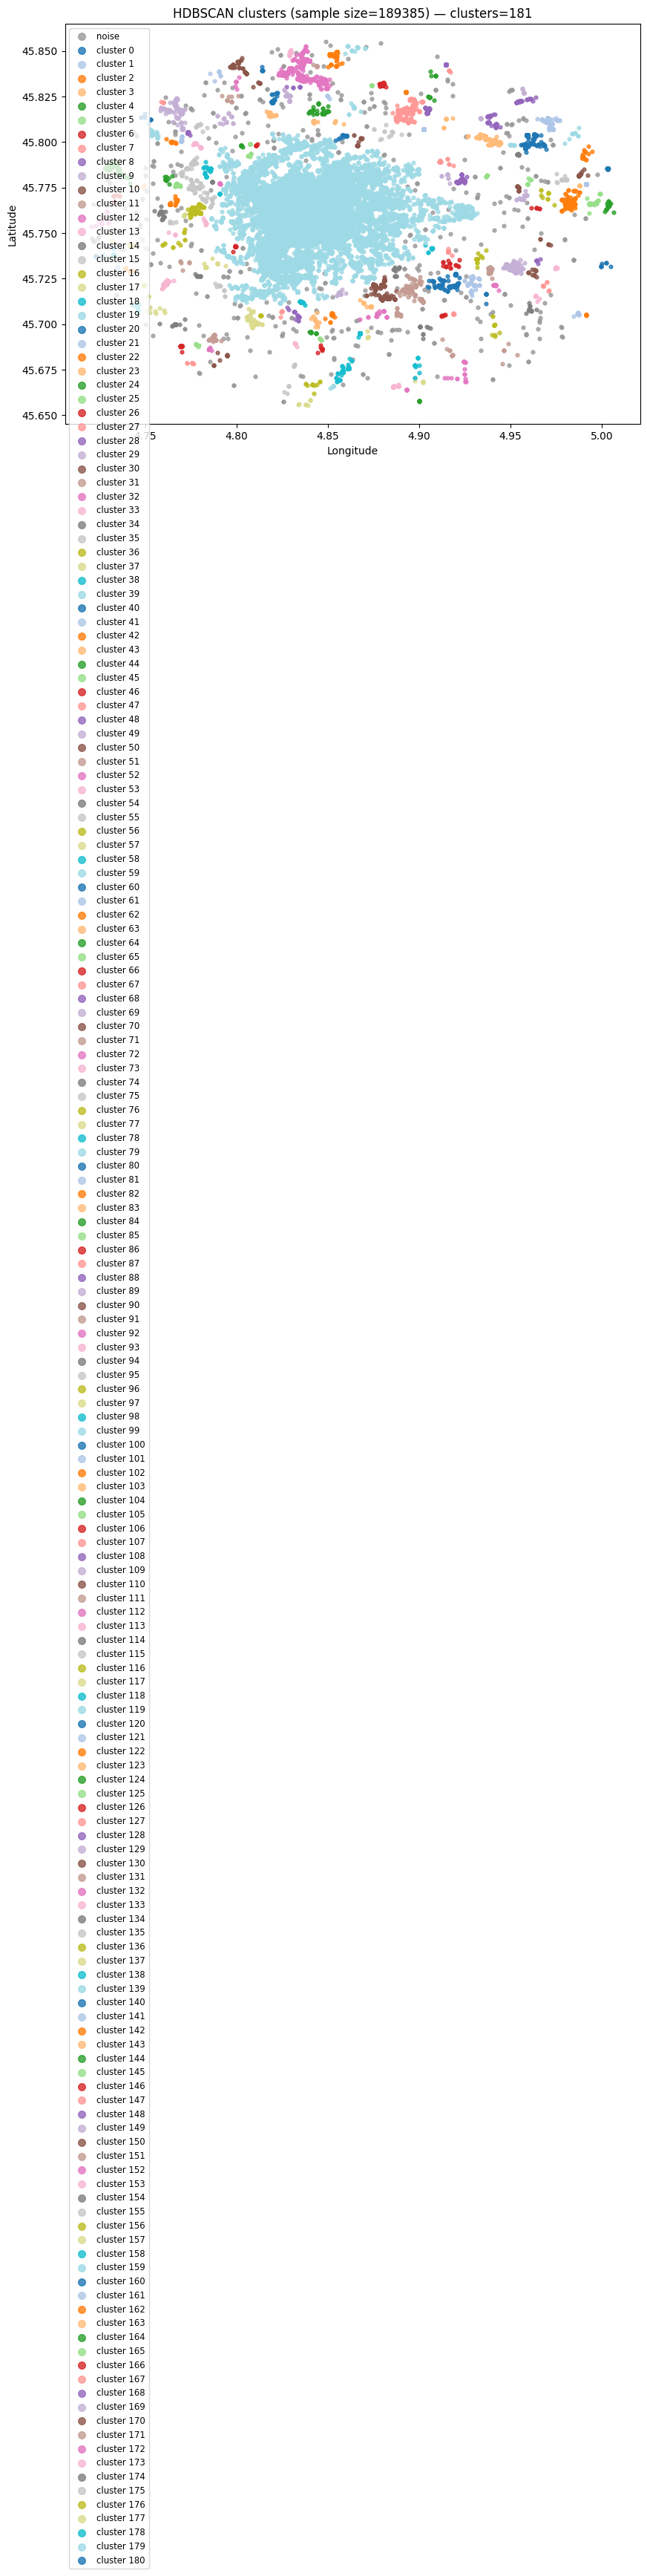

In [6]:
# copy=True makes sure that if there's changes in the data, HDBSCAN makes a safe copy of it
# min_cluster_size defines the min amount of points for a set to be considered a cluster
# cluster_selection_epsilon defines the distance to include a point in a cluster set
# n_jobs parallelises the calculation. -1 means use all processors
# store_centers="centroid" to store avg of a cluster
hdbscan_clusterer = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_epsilon=0.003, copy=True, n_jobs=-1)
hdbscan_clusterer.fit(X)
labels = hdbscan_clusterer.labels_

plot_model(hdbscan_clusterer, X)


In [ ]:
from hdbscan.validity import validity_index

# calcule un score en fonction de la stabilité des clusters (privilégie donc les plus grands clusters)
# à voir comment fonctionne exactement

#une autre façon de faire serait peut-etre d'utiliser la librairie hdbscan, puisqu'ils 
#nous donnent le dendogram of the merging
# it also has a feature for automatically selecting the clusters with the maximum score
# https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
score = validity_index(X, labels)
score

MemoryError: Unable to allocate 180. GiB for an array with shape (155369, 155369) and data type float64

K-Means++

K-Means is the most widely used clustering algorithm. The objective is to minimize the sum of distances between the data points and the cluster centroid to identify the correct group that each data point should belong to. IMPORTANT: It is uncapable of filtering out noise, it needs data treating first to work properly.

A defined number of centroids (= number of clusters) are randomly dropped into the vector space of the unlabeled data (initialization).
Each data point measures itself to each centroid (usually using Euclidean distance) and assigns itself to the closest one.
The centroids relocate to the mean of their assigned data points.
Steps 2–3 repeat until the ‘optimal’ clusters are produced.

Kmeans++ tries to find a better initialization, by randomly dropping a centroid and selecting the other centroids as the furthest existing points. This assumes that clusters tend to be further appart.

Sklearn uses Greedy Kmeans++, which attempts different starts to Kmeans++.

To understand: 
As both KMeans and MiniBatchKMeans optimize a non-convex objective function, their clustering is not guaranteed to be optimal for a given random init. Even further, on sparse high-dimensional data such as text vectorized using the Bag of Words approach, k-means can initialize centroids on extremely isolated data points. Those data points can stay their own centroids all along.




[[45.71664066  4.87435997]
 [45.76121469  4.85961193]
 [45.77208787  4.83118835]
 [45.83729589  4.82636636]
 [45.73010963  4.95229752]
 [45.73156362  4.81935806]
 [45.76216688  4.82184375]
 [45.70120205  4.76697324]
 [45.80525338  4.95641701]
 [45.78158017  4.87409066]
 [45.73193312  4.73490467]
 [45.75913737  4.84038239]
 [45.77606839  4.85552797]
 [45.76265969  4.78120384]
 [45.81232844  4.7684304 ]
 [45.7689169   4.98339764]
 [45.81416136  4.89789864]
 [45.68129434  4.86670979]
 [45.75855943  4.83327505]
 [45.77486975  4.80782552]
 [45.76417474  4.92443301]
 [45.79860091  4.83787501]
 [45.76707519  4.83492879]
 [45.75197682  4.88155698]
 [45.72065461  4.92105928]
 [45.75017728  4.83847983]
 [45.76407591  4.85022947]
 [45.84785323  4.85266253]
 [45.76810759  4.8783409 ]
 [45.74100147  4.87041065]
 [45.78458759  4.7328354 ]
 [45.72482069  4.83100779]
 [45.74989032  4.85313645]
 [45.78445469  4.85514223]
 [45.75110897  4.826045  ]
 [45.75950311  4.80948229]
 [45.76800882  4.76440143]
 

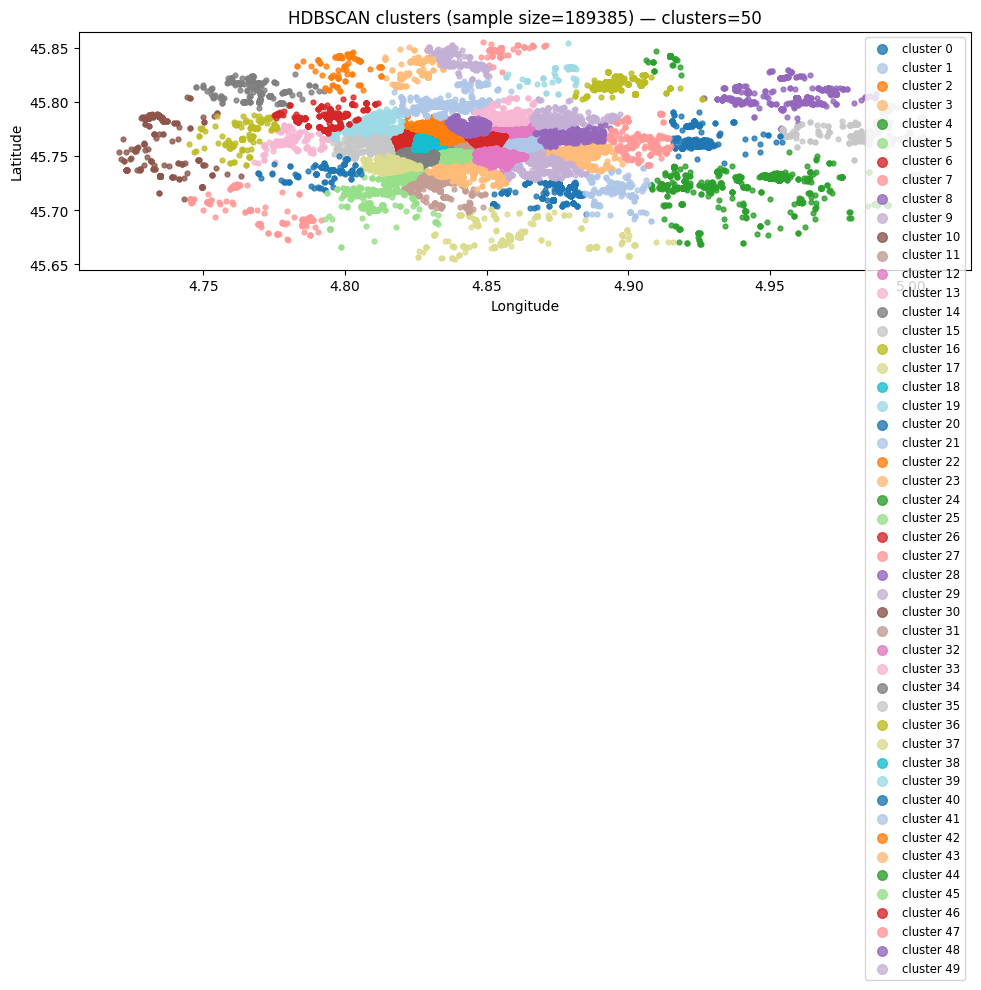

In [7]:
# n_clustersint, default=8 -> fixes the amount of clusters
# max_iter -> nb of max iterations for a single run (only one run in Kmeans++, n_init for Kmeans)
km_clustering = KMeans(init="k-means++", n_clusters=50, random_state=0)

km_clustering.fit_predict(X)

print(km_clustering.cluster_centers_)

plot_model(km_clustering, X)

Isolation Forest

Isolation Forest is not a clustering algorithm, but an anomaly detector one. 
It tries, by using trees, to isolate points. It does that by selecting a random cut (between min and max of lon or lat), and points that get isolated first are considered anomalous.

This makes it so that isolated points are separeted first. The main problem is that it does not handle different concentration clusters nor smaller clusters.

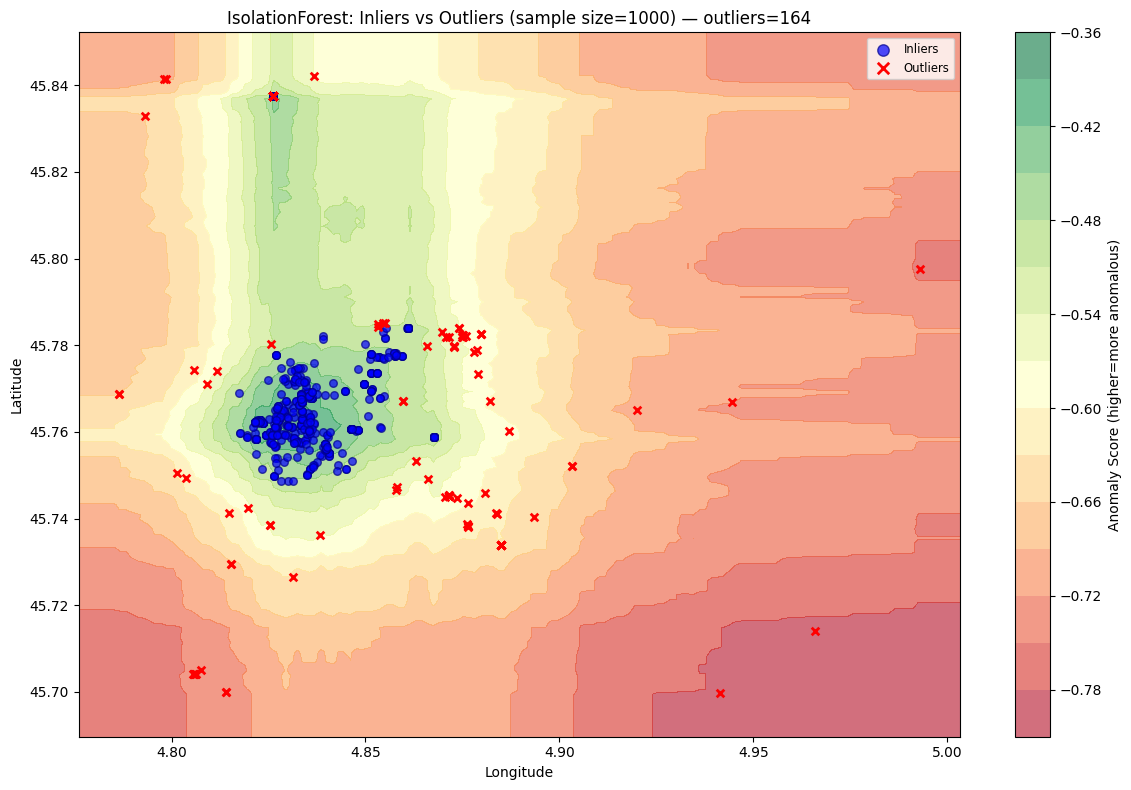

In [10]:
isof_clustering = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

isof_clustering.fit_predict(X)

plot_if(isof_clustering, X)

Filling predictions.csv

In [8]:
# Support function
def _infer_model_column(model):
    name = model.__class__.__name__.lower()

    if "hdbscan" in name:
        return "hdbscan"
    elif "dbscan" in name:
        return "dbscan"
    elif "kmeans" in name:
        return "kmean"
    elif "isolationforest" in name:
        return "isolation_forest"
    else:
        raise ValueError(f"Unknown model type: {model.__class__.__name__}")

def write_predictions(X, model, labels=None, path="../data/predictions.csv"
):
    if labels is None:
        if model.labels_.any():
            labels = model.labels_
        else:
            raise ValueError("No labels for {model}")
        
    column = _infer_model_column(model)

    preds = pd.read_csv(path)

    if "id" not in preds.columns:
        raise ValueError("predictions.csv must contain an 'id' column")

    if "id" not in X.columns:
        raise ValueError("X must contain an 'id' column")

    if len(X) > len(labels):
        raise ValueError("X lenght greater than labels")

    tmp = pd.DataFrame({
        "id": X["id"].values,
        column: labels
    })

    preds = preds.merge(
        tmp,
        on="id",
        how="left",
        suffixes=("", "_new")
    )

    # overwrite only the correct column
    preds[column] = preds[f"{column}_new"].combine_first(preds[column])
    preds.drop(columns=[f"{column}_new"], inplace=True)

    preds.to_csv(path, index=False)

# Creates header for the predictions.csv file
def initialize_predictions_from_cleaned(
    cleaned_path="../data/data_cleaned.csv",
    output_path="../data/predictions.csv"
):
    df = pd.read_csv(cleaned_path)
    print(df.head())
    if "id" not in df.columns:
        raise ValueError("data_cleaned.csv must contain an 'id' column")

    preds = pd.DataFrame({
        "id": df["id"],
        "hdbscan": pd.NA,
        "dbscan": pd.NA,
        "kmean": pd.NA,
        "isolation_forest": pd.NA
    })

    preds.to_csv(output_path, index=False)

In [ ]:
from pathlib import Path


def count_points_per_cluster(model, ignore_noise=True):
    """
    Retourne un DataFrame avec:
    - cluster_id
    - n_points
    """
    if not hasattr(model, "labels_"):
        raise ValueError(f"No labels for {model}")
    
    labels = model.labels_
    s = pd.Series(labels, name="cluster_id")

    if ignore_noise:
        s = s[s != -1]

    counts = (
        s
        .value_counts()
        .rename("n_points")
        .reset_index()
        .sort_values("cluster_id")
        .reset_index(drop=True)
    )

    return counts

# Extract and save cluster centroids to a CSV file
def extract_cluster_centroids(
    X,
    model,
    labels=None,
    path="../data/centroids.csv"
):
    algo = model.__class__.__name__.lower()

    if labels is None:
        if hasattr(model, "labels_"):
            labels = model.labels_
        else:
            raise ValueError(f"No labels for {model}")

    count = count_points_per_cluster(model)
    # ---------- KMEANS ----------
    if "kmeans" in algo:
        centers = model.cluster_centers_

        cluster_centroids = [
            {
                "algo": "kmean",
                "cluster_id": i,
                "lat": centers[i][0],
                "long": centers[i][1],
                "n_points": int(count[count["cluster_id"] == i]["n_points"]) if i in count["cluster_id"].values else 0
            }
            for i in range(len(centers))
        ]


    # ---------- DBSCAN / HDBSCAN ----------
    elif "dbscan" in algo or "hdbscan" in algo:
        df = X.copy()
        df["cluster"] = labels

        # ignorer le bruit
        df = df[df["cluster"] != -1]

        centroids = (
            df
            .groupby("cluster")[["lat", "long"]]
            .mean()
            .reset_index()
        )

        cluster_centroids = [
            {
                "algo": "hdbscan" if "hdbscan" in algo else "dbscan",
                "cluster_id": row["cluster"],
                "lat": row["lat"],
                "long": row["long"]
            }
            for _, row in centroids.iterrows()
        ]

    else:
        raise ValueError(f"Unsupported model type: {model.__class__.__name__}")

    # ---------- ÉCRITURE CSV ----------
    df_new = pd.DataFrame(cluster_centroids)

    path = Path(path)
    
    if path.exists():
        df_old = pd.read_csv(
            path,
            usecols=["algo", "cluster_id", "lat", "long"]
        )
        df_old = df_old[df_old["algo"] != df_new["algo"].iloc[0]]

        df = pd.concat([df_old, df_new], ignore_index=True)
    else:
        df = df_new

    df.to_csv(path, index=False)

    return df_new

In [ ]:

write_predictions(sample, km_clustering)
write_predictions(sample, dbscan_clusterer)
write_predictions(sample, hdbscan_clusterer)
#extract_cluster_centroids(sample, km_clustering)
#extract_cluster_centroids(sample, dbscan_clusterer)
#extract_cluster_centroids(sample, hdbscan_clusterer)

,algo,cluster_id,lat,long
0,hdbscan,0.0,45.837492,4.825984
1,hdbscan,1.0,45.703151,4.808117
2,hdbscan,2.0,45.758872,4.867681
3,hdbscan,3.0,45.743846,4.873109
4,hdbscan,4.0,45.734487,4.884786
5,hdbscan,5.0,45.783927,4.860969
6,hdbscan,6.0,45.760723,4.846995
7,hdbscan,7.0,45.781069,4.871745
8,hdbscan,8.0,45.782624,4.874902
9,hdbscan,9.0,45.783724,4.854488


In [ ]:
export_important_points(
    algo_name="kmean",
    points=[   